In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


In [2]:
def hparameters_dict(N_EPOCHS=500,N_SAMPLES=10000,BATCH_SIZE=100,lr=1e-4):
    hp = { "N_EPOCHS":N_EPOCHS, 
            "N_SAMPLES":N_SAMPLES,
            "BATCH_SIZE":BATCH_SIZE,
            "lr":lr,
        }
    return hp

In [5]:
def f(a,**kwargs):
    hp = hparameters(**kwargs)
    print(N)

In [6]:
def train(encoder,decoder,q,p_x,**kwargs):
    hp = hparameters(**kwargs)
    x_samples = p_x.sample((N_SAMPLES,))[:,None]
    x_sorted,indices = x_samples.sort(dim=0)
    x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
    x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
    return

Text(0, 0.5, 'Encoding')

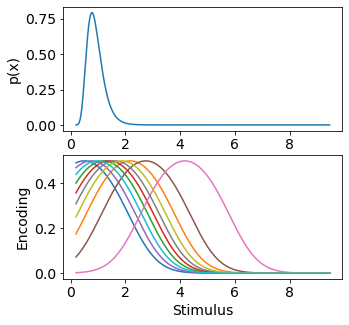

In [7]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.4,0.6]))
gs = torch.distributions.normal.Normal(torch.Tensor([-4,4]),torch.tensor([1,2]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(0,.5)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES = 10000
lr = 1e-4
BATCH_SIZE = 100
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
#enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/(0.5*N))[None,:])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_fine,10**p_x.log_prob(x_fine).detach())
axs[0].set_xlabel("Stimulus")
axs[0].set_ylabel("p(x)")
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
axs[1].plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
axs[1].set_xlabel("Stimulus")
axs[1].set_ylabel("Encoding")
#axs2 = axs.twinx()


In [8]:
#Minimax training
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
#lr = 1e-4
lVec,dVec,rVec,bVec,CVec = ([] for _ in range(5))
opt = torch.optim.Adam(params,lr)
#Scheduled Beta
beta = 1
t = 0
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    #beta=1
    for x_ in x_data:
        rate = q(enc,x_)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical_linear(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =   rate + beta*(distortion+1.)
        opt.zero_grad()
        loss.backward()
        opt.step()
        C_ext = distortion.item()
        if t == 0:
            C_tma = distortion.item()
        else:
            C_tma = 0.99*CVec[-1] + 0.01*C_ext

        C_t = C_ext + (C_tma - C_ext)
        lav += distortion + rate
        dav += distortion
        rav += rate
        CVec.append(C_t)
        beta *= np.exp(1e-4*C_t)
        t +=1
        print(beta)
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))
    bVec.append(1/beta)
    print(f"Epoch: {e} || ELBO: {lVec[-1]}")

1.000165043859252
1.0003300449003585
1.0004951217974185
1.0006602003523086
1.0008253139686987
1.0009906137607818
1.0011559905262686
1.0013213424957672
1.0014867606478637
1.0016522095435072
1.0018178322767441
1.0019833495832922
1.0021488590284235
1.0023143205947465
1.0024797509606274
1.0026451368960207
1.0028104445995731
1.002975668853477
1.0031409026807017
1.0033061447236837
1.0034713491802913
1.0036364272927314
1.0038013785468056
1.0039663318062237
1.0041313550125759
1.004296266593637
1.0044611311686167
1.0046258863723463
1.0047907566113203
1.0049556484097437
1.0051204055931073
1.0052850748115845
1.0054496063428524
1.0056141712058375
1.0057786332880456
1.0059430524941333
1.0061074233189484
1.006271786219649
1.0064360428472798
1.0066002248465078
1.0067644888976057
1.0069287457735239
1.0070930193888035
1.0072571884864507
1.0074212843486672
1.007585452421416
1.0077494074144122
1.0079132250115195
1.0080769131947893
1.0082407264685274
1.0084045261804881
1.0085684794608343
1.008732322341737

KeyboardInterrupt: 

In [2]:
fig,ax = training_plots(lVec,dVec,rVec,bVec)
#fig.savefig("beta1_training.pdf")

NameError: name 'training_plots' is not defined

In [10]:
min(dVec)

-0.43585906982421874

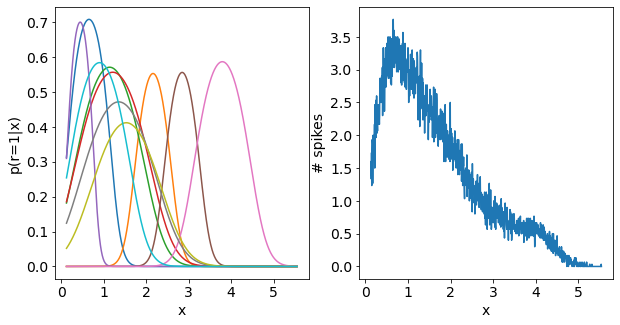

In [11]:
fig,axs = encoder_plots(enc,x_fine)
#fig.savefig("beta1_encoder.pdf")

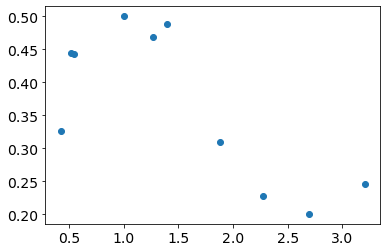

In [20]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))

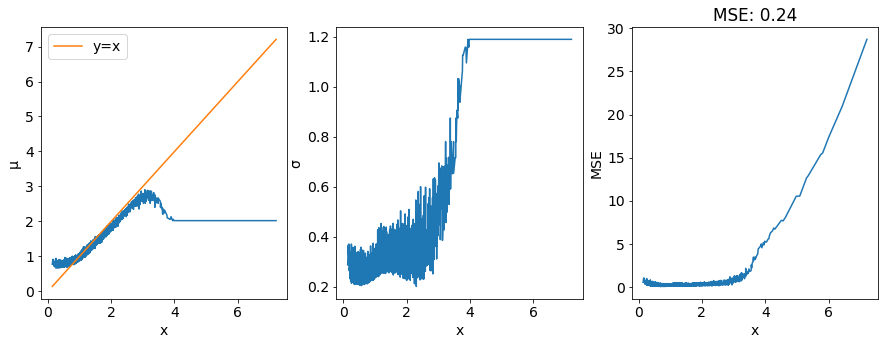

In [21]:
fig,axs = decoder_plots(enc,dec,x_sorted)
#fig.savefig("beta1_decoder.pdf")

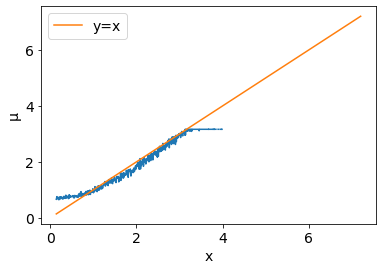

In [22]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')


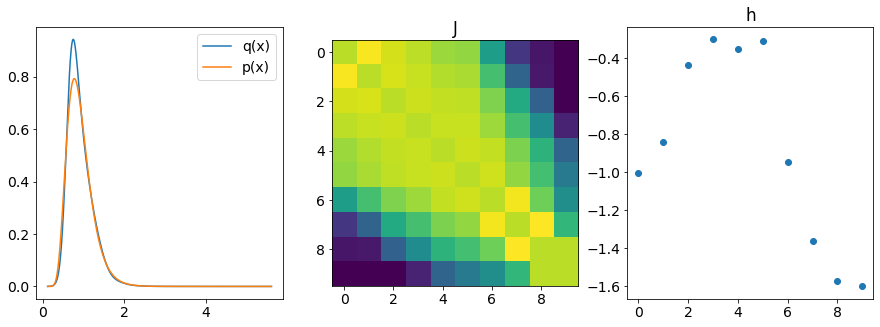

In [10]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
#fig.savefig("beta1_gm.pdf")

In [11]:
h =torch.histogram(x_samples)

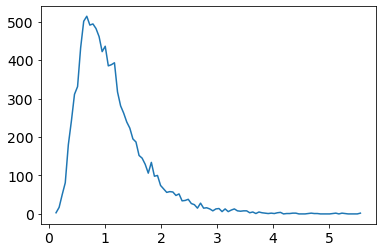

In [12]:
plt.plot(h.bin_edges[0:-1],h.hist)

In [13]:
q.h

Parameter containing:
tensor([[-0.4349, -1.3636, -0.2991, -0.3484, -1.0055, -1.5723, -1.6025, -0.3095,
         -0.9477, -0.8422]], requires_grad=True)

In [14]:
t = 1
for i in range(5):
    t *=(i+1)

In [108]:
t

120